In [1]:
import numpy 
import pandas
import cobra
from cobra.io import load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model, load_model, to_json
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(20, 10), 
                            'axes.labelsize':40})

import seaborn
from cobra import Model, Reaction, Metabolite
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from cobra.flux_analysis import pfba

## 1. Generate fluxes for 100 points on an Ecoli.core Model with decreasing oxygen

In [2]:
model = load_model('textbook')

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
model

Name,e_coli_core
Memory address,0x07fe4f175f310
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


In [6]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


In [7]:
solution = model.optimize()
solution.objective_value

0.8739215069684304

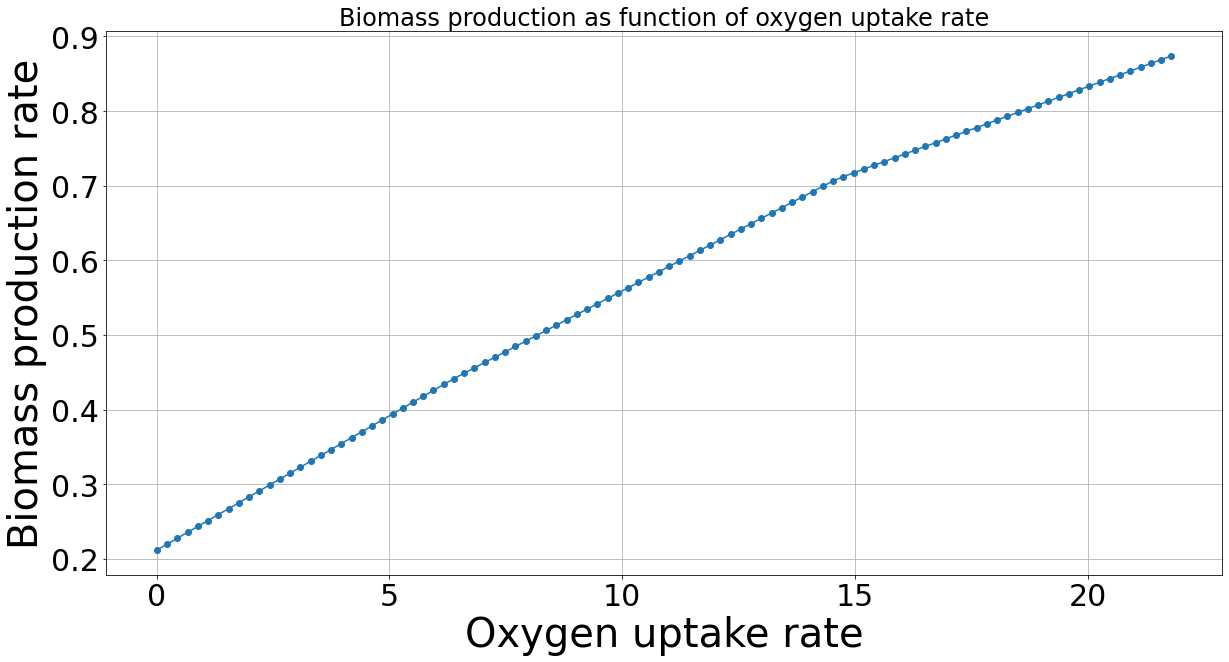

In [8]:
# higher_boundary
# model is exploring 21.8 units of o2
# Explore 100 points from 0 to 21.8 
# Then see impact of biomass
# x see impact of biomass
# do FBA and "pFBA"
# 
oxygen_fluxes = numpy.linspace(0, 21.8, 100)  

resulting_fluxes = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = -flux  # NOTE: the negative sign, uptake reactions are typically negative in cobra models
    solution = model.optimize()
    if solution.status == 'optimal':
        resulting_fluxes.append(solution.objective_value)
    else:
        resulting_fluxes.append(numpy.nan)

matplotlib.pyplot.figure(figsize = (20, 10))
matplotlib.pyplot.plot(oxygen_fluxes, resulting_fluxes, 'o-')  # added markers
matplotlib.pyplot.xlabel('Oxygen uptake rate')
matplotlib.pyplot.ylabel('Biomass production rate')
matplotlib.pyplot.title('Biomass production as function of oxygen uptake rate')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.show()


In [9]:
oxygen_fluxes

array([ 0.        ,  0.22020202,  0.44040404,  0.66060606,  0.88080808,
        1.1010101 ,  1.32121212,  1.54141414,  1.76161616,  1.98181818,
        2.2020202 ,  2.42222222,  2.64242424,  2.86262626,  3.08282828,
        3.3030303 ,  3.52323232,  3.74343434,  3.96363636,  4.18383838,
        4.4040404 ,  4.62424242,  4.84444444,  5.06464646,  5.28484848,
        5.50505051,  5.72525253,  5.94545455,  6.16565657,  6.38585859,
        6.60606061,  6.82626263,  7.04646465,  7.26666667,  7.48686869,
        7.70707071,  7.92727273,  8.14747475,  8.36767677,  8.58787879,
        8.80808081,  9.02828283,  9.24848485,  9.46868687,  9.68888889,
        9.90909091, 10.12929293, 10.34949495, 10.56969697, 10.78989899,
       11.01010101, 11.23030303, 11.45050505, 11.67070707, 11.89090909,
       12.11111111, 12.33131313, 12.55151515, 12.77171717, 12.99191919,
       13.21212121, 13.43232323, 13.65252525, 13.87272727, 14.09292929,
       14.31313131, 14.53333333, 14.75353535, 14.97373737, 15.19

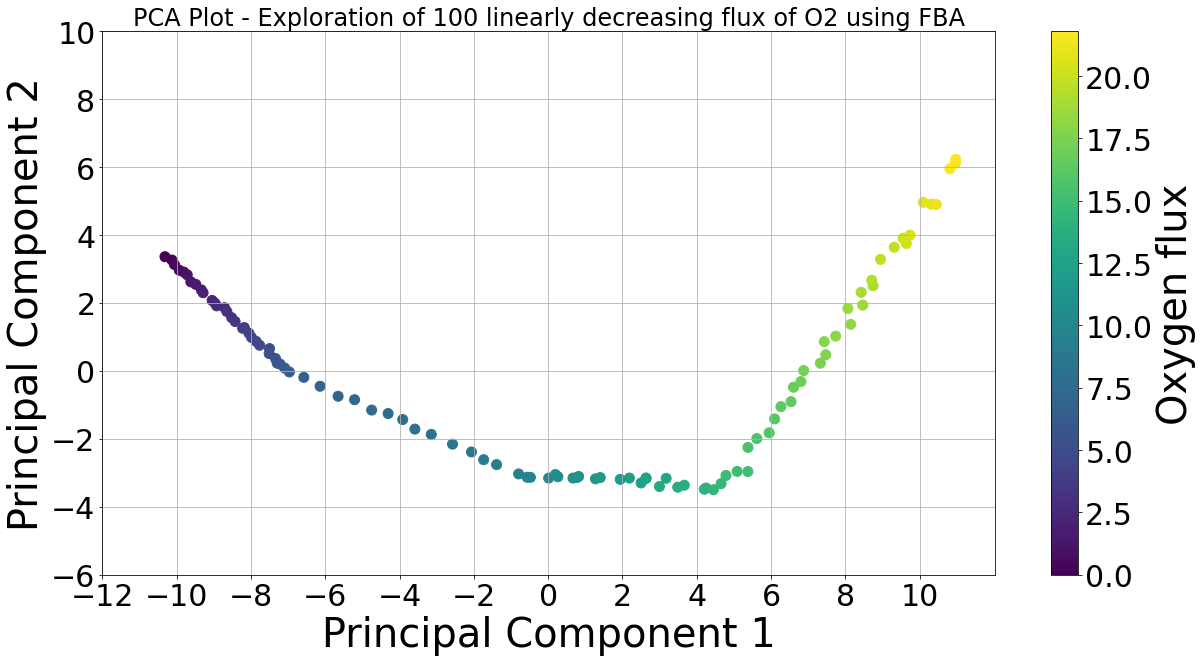

In [10]:
all_fluxes = []
oxygen_fluxes_after_fba = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = -flux
    solution = model.optimize()  # FBA
    if solution:
        all_fluxes.append(solution.fluxes)
        oxygen_fluxes_after_fba.append(numpy.abs(solution.fluxes['EX_o2_e']))
    else:
        all_fluxes.append([numpy.nan]*len(model.reactions))
        oxygen_fluxes_after_fba.append(numpy.nan)

df = pandas.DataFrame(all_fluxes, columns=[r.id for r in model.reactions])

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.fillna(0))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(scaled_df) 
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig, ax = matplotlib.pyplot.subplots(figsize = (20, 10))
scatter = ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
                     c = oxygen_fluxes_after_fba, cmap = 'viridis', s = 100) # using oxygen_fluxes for color


x_ticks = numpy.arange(-12, 12, step=2)
y_ticks = numpy.arange(-6, 12, step=2)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Plot - Exploration of 100 linearly decreasing flux of O2 using FBA')
fig.colorbar(scatter, ax = ax, label = 'Oxygen flux')
ax.grid(True)
matplotlib.pyplot.show()

## 2. Applying the transformations

In [40]:
def flux_transformer(v):
    '''
    This function transforms fluxes into log2 scale with three additions:
    - zero values are kept.
    - values between 0 and 2 are adjusted to fit below one.
    - negative fluxes are considered. 
    '''

    def adjusted(v):
        new = (numpy.log2(v + 0.125) + 3) / 4
        return numpy.min([new, 1])

    if v == 0:
        vprime = 0
    elif v > 0:
        if v < 2:
            vprime = adjusted(v)
        else:
            vprime = numpy.log2(v)
    elif v < 0:
        v = numpy.abs(v)
        if v < 2:
            vprime = -adjusted(v)
        else:
            vprime = -numpy.log2(v)
    else:
        raise ValueError('found value not considered')

    return vprime


all_fluxes_transformed = []
oxygen_fluxes_after_pfba = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = -flux
    solution = pfba(model)  # pFBA
    if solution:
        fluxes_transformed = [flux_transformer(flux_value) for flux_value in solution.fluxes]
        all_fluxes_transformed.append(fluxes_transformed)
        oxygen_fluxes_after_pfba.append(numpy.abs(solution.fluxes['EX_o2_e']))
    else:
        all_fluxes_transformed.append([numpy.nan]*len(model.reactions))
        oxygen_fluxes_after_pfba.append(numpy.nan)



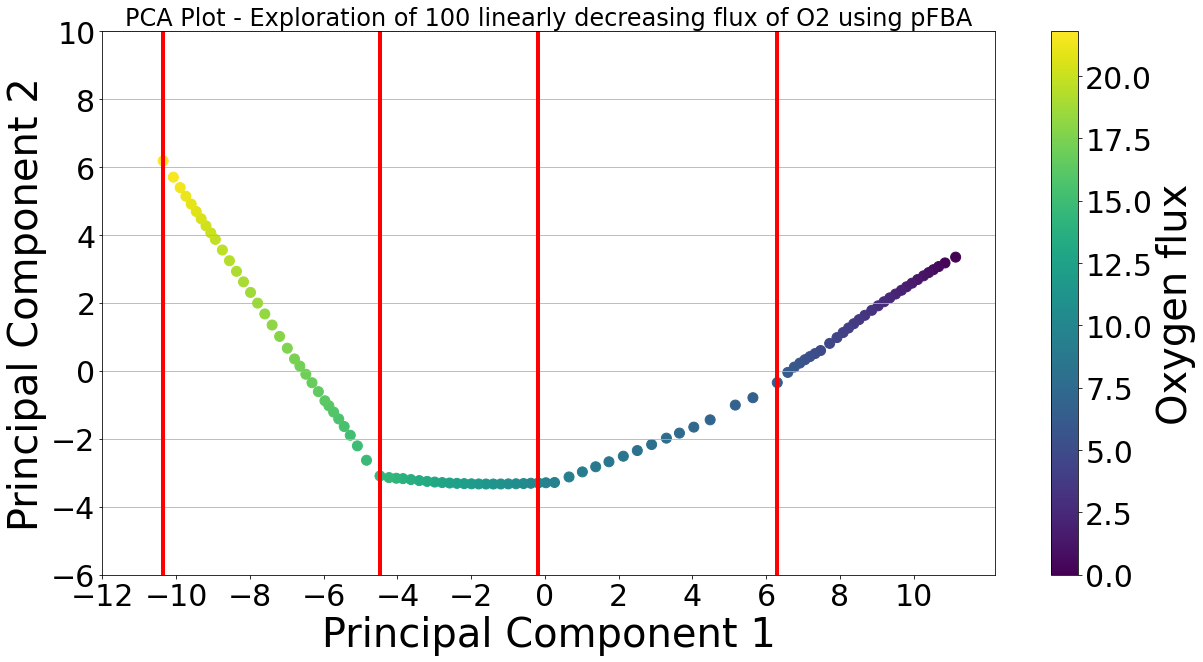

In [61]:
df = pandas.DataFrame(all_fluxes_transformed, columns=[r.id for r in model.reactions])

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.fillna(0))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(scaled_df) 
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig, ax = matplotlib.pyplot.subplots(figsize = (20, 10))
scatter = ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
                     c = oxygen_fluxes_after_pfba, cmap = 'viridis', s = 100) # using oxygen_fluxes for color

# Label every 10th point
#for i in range(0, len(principalDf), 10): 
    #ax.text(principalDf['principal component 1'].iloc[i], principalDf['principal component 2'].iloc[i], str(i))

# Add vertical lines
explorations_to_mark = [29, 45, 66, 99]
for i in explorations_to_mark:
    ax.axvline(x = principalDf['principal component 1'].iloc[i], color = 'r', linestyle = '-', lw = 4)

x_ticks = numpy.arange(-12, 12, step = 2)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Plot - Exploration of 100 linearly decreasing flux of O2 using pFBA')
fig.colorbar(scatter, ax = ax, label = 'Oxygen flux')
ax.grid(axis = 'y')
matplotlib.pyplot.show()


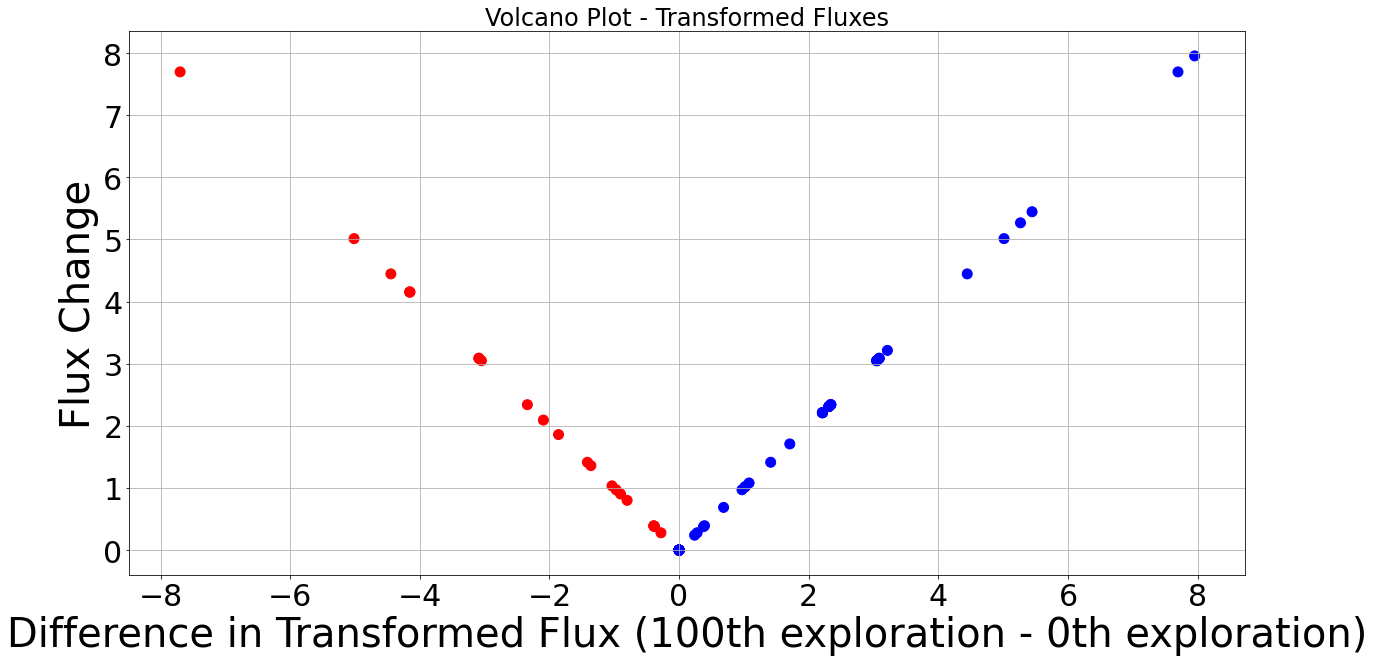

In [32]:
all_fluxes_transformed = [[flux_transformer(v) for v in flux_list] for flux_list in all_fluxes]

df_0th_transformed = pandas.DataFrame(all_fluxes_transformed[0], index=[r.id for r in model.reactions]).transpose()
df_100th_transformed = pandas.DataFrame(all_fluxes_transformed[-1], index=[r.id for r in model.reactions]).transpose()

difference_fluxes_transformed = df_100th_transformed.iloc[0] - df_0th_transformed.iloc[0]

df_difference_fluxes_transformed = difference_fluxes_transformed.reset_index()

df_difference_fluxes_transformed.columns = ['Flux Name', 'Flux Difference']

positive_fluxes = df_difference_fluxes_transformed[df_difference_fluxes_transformed['Flux Difference'] >= 0]
negative_fluxes = df_difference_fluxes_transformed[df_difference_fluxes_transformed['Flux Difference'] < 0]

abs_flux_changes_transformed = difference_fluxes_transformed.abs()

colors = ['blue' if x >= 0 else 'red' for x in difference_fluxes_transformed]

fig, ax = matplotlib.pyplot.subplots(figsize = (20, 10))

ax.scatter(difference_fluxes_transformed, abs_flux_changes_transformed, c = colors, s = 100)
ax.set_xlabel('Difference in Transformed Flux (100th exploration - 0th exploration)')
ax.set_ylabel('Flux Change')
ax.set_title('Volcano Plot - Transformed Fluxes')
ax.grid(True)

matplotlib.pyplot.show()


In [39]:
negative_fluxes

,Flux Name,Flux Difference
13,CO2t,-5.013869e+00
17,ENO,-3.777352e-01
19,EX_ac_e,-3.088071e+00
23,EX_etoh_e,-3.049536e+00
24,EX_for_e,-4.154184e+00
30,EX_h_e,-8.014744e-01
34,EX_nh4_e,-1.413775e+00
35,EX_o2_e,-4.446223e+00
36,EX_pi_e,-9.713148e-01
39,FBA,-3.886959e-01


In [62]:
loadings = pandas.DataFrame(pca.components_.T, columns = ['PC1', 'PC2'], index = df.columns)

# Rank reactions based on absolute loading, since loading can be negative, 
# and a large negative value is also influential.
loadings['PC1_rank'] = loadings['PC1'].abs().rank(ascending=False)
loadings['PC2_rank'] = loadings['PC2'].abs().rank(ascending=False)

# Sort by rank
loadings_sorted_PC1 = loadings.sort_values(by = 'PC1_rank')
loadings_sorted_PC2 = loadings.sort_values(by = 'PC2_rank')

print(loadings_sorted_PC1)
print(loadings_sorted_PC2)


               PC1       PC2  PC1_rank  PC2_rank
GLUDy     0.146563  0.007169       1.0      57.0
NH4t     -0.146442 -0.014177       2.5      53.5
EX_nh4_e  0.146442  0.014177       2.5      53.5
PYK       0.145962 -0.013020       4.0      55.0
GLNS     -0.145222 -0.024768       5.0      52.0
...            ...       ...       ...       ...
MALS     -0.000000 -0.000000      78.5      78.5
MALt2_2  -0.000000 -0.000000      78.5      78.5
ME1      -0.000000 -0.000000      78.5      78.5
NADTRHD  -0.000000 -0.000000      78.5      78.5
LDH_D    -0.000000 -0.000000      78.5      78.5

[95 rows x 4 columns]
              PC1      PC2  PC1_rank  PC2_rank
FUM     -0.110515  0.23411      55.5       2.5
SUCOAS   0.110515 -0.23411      55.5       2.5
SUCDi   -0.110515  0.23411      55.5       2.5
MDH     -0.110515  0.23411      55.5       2.5
AKGDH   -0.110515  0.23411      53.0       5.0
...           ...      ...       ...       ...
MALS    -0.000000 -0.00000      78.5      78.5
MALt2_2 -0.00

In [63]:
print("Top 20 fluxes for PC1:")
print(loadings_sorted_PC1.head(20))

print('____________________________________________________________________________')

print("\nTop 20 fluxes for PC2:")
print(loadings_sorted_PC2.head(20))


Top 20 fluxes for PC1:
                         PC1       PC2  PC1_rank  PC2_rank
GLUDy               0.146563  0.007169       1.0      57.0
NH4t               -0.146442 -0.014177       2.5      53.5
EX_nh4_e            0.146442  0.014177       2.5      53.5
PYK                 0.145962 -0.013020       4.0      55.0
GLNS               -0.145222 -0.024768       5.0      52.0
PGM                -0.144862 -0.048214       6.5      47.5
ENO                 0.144862  0.048214       6.5      47.5
Biomass_Ecoli_core -0.144071 -0.039558       8.0      49.0
EX_co2_e           -0.143590 -0.029566       9.5      50.5
CO2t                0.143590  0.029566       9.5      50.5
PGK                -0.143433 -0.063783      11.5      42.5
GAPD                0.143433  0.063783      11.5      42.5
PIt2r              -0.143344  0.059981      13.5      45.5
EX_pi_e             0.143344 -0.059981      13.5      45.5
PPC                -0.142508  0.060468      15.0      44.0
FBA                 0.140158  0.0

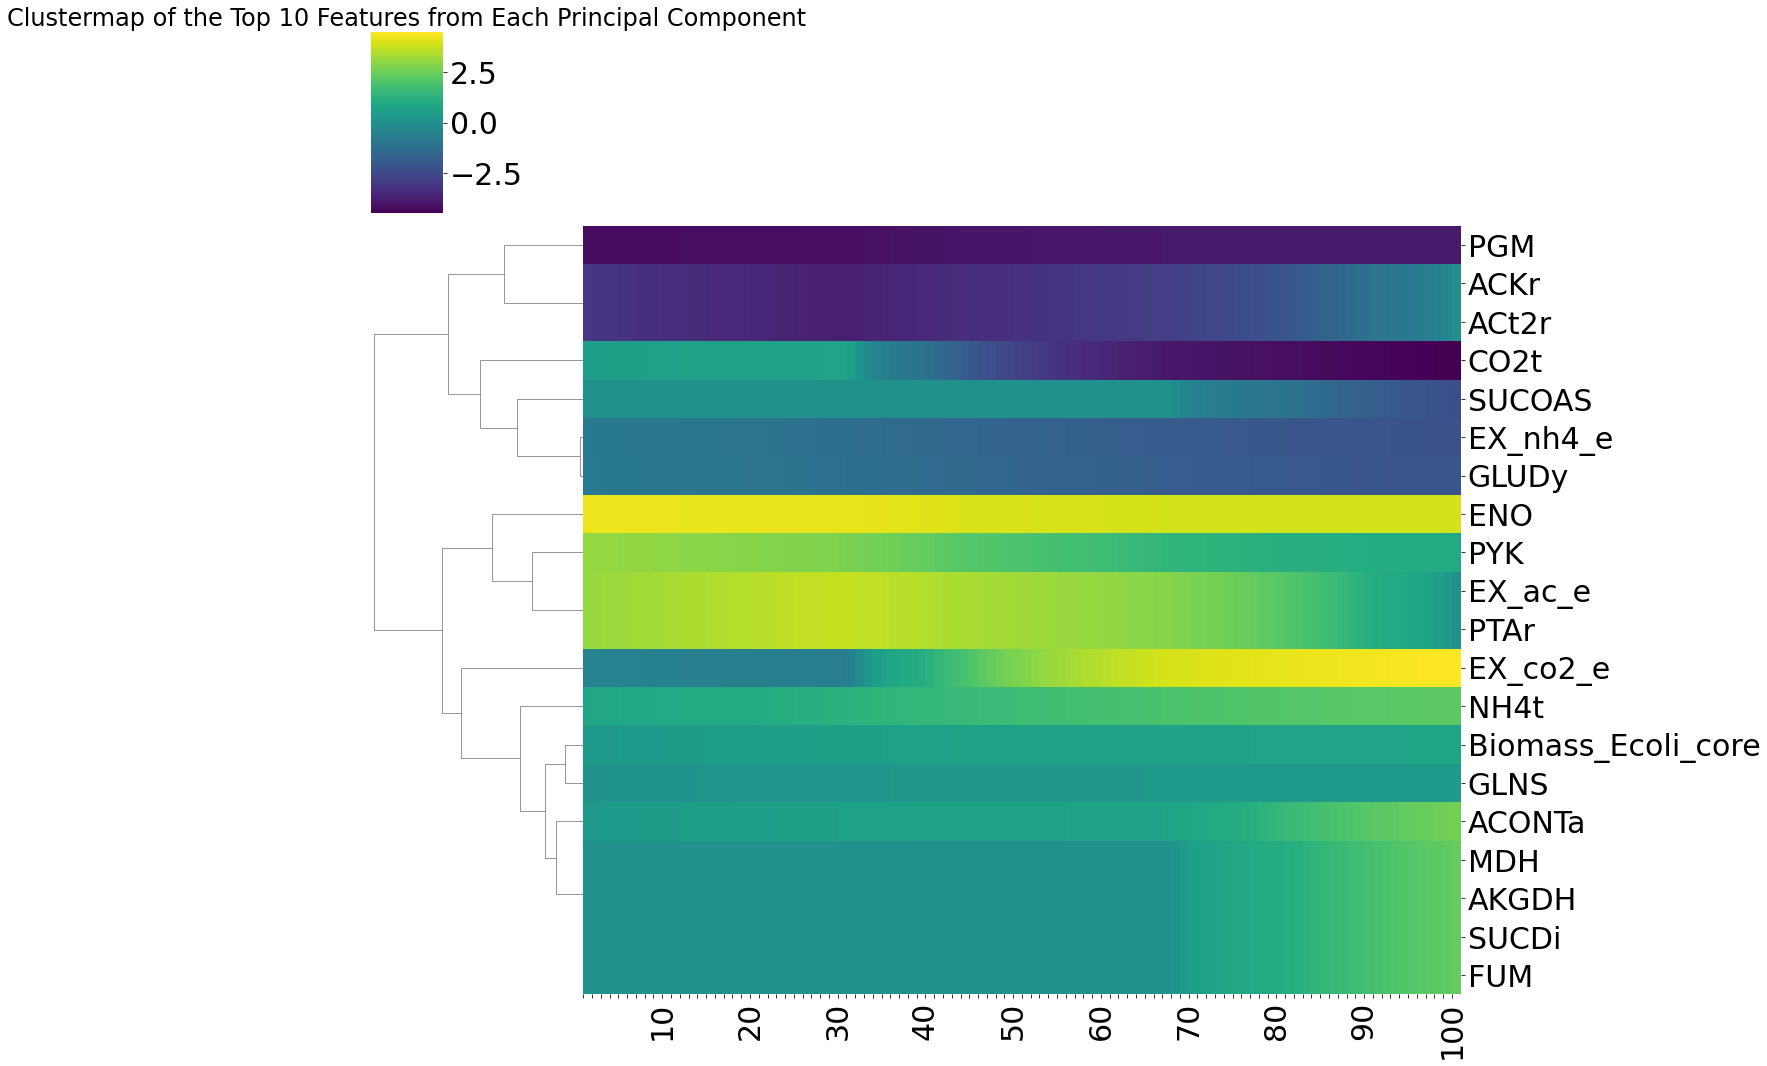

In [64]:
top_reactions_PC1 = loadings_sorted_PC1.index[:10].tolist()
top_reactions_PC2 = loadings_sorted_PC2.index[:10].tolist()

top_reactions = list(set(top_reactions_PC1 + top_reactions_PC2))

top_flux_data = df[top_reactions].transpose()

g = seaborn.clustermap(top_flux_data, cmap = 'viridis', col_cluster = False, 
               yticklabels = True, xticklabels = False, figsize = (20, 14))

labels = [str(i) if i % 10 == 0 else '' for i in range(1, 101)] 

g.ax_heatmap.set_xticks(numpy.arange(100))
g.ax_heatmap.set_xticklabels(labels, rotation = 90)

matplotlib.pyplot.title('Clustermap of the Top 10 Features from Each Principal Component')

matplotlib.pyplot.show()
#row fluxes
#columns would be the 100 simulations
#use clustermap from seaborn


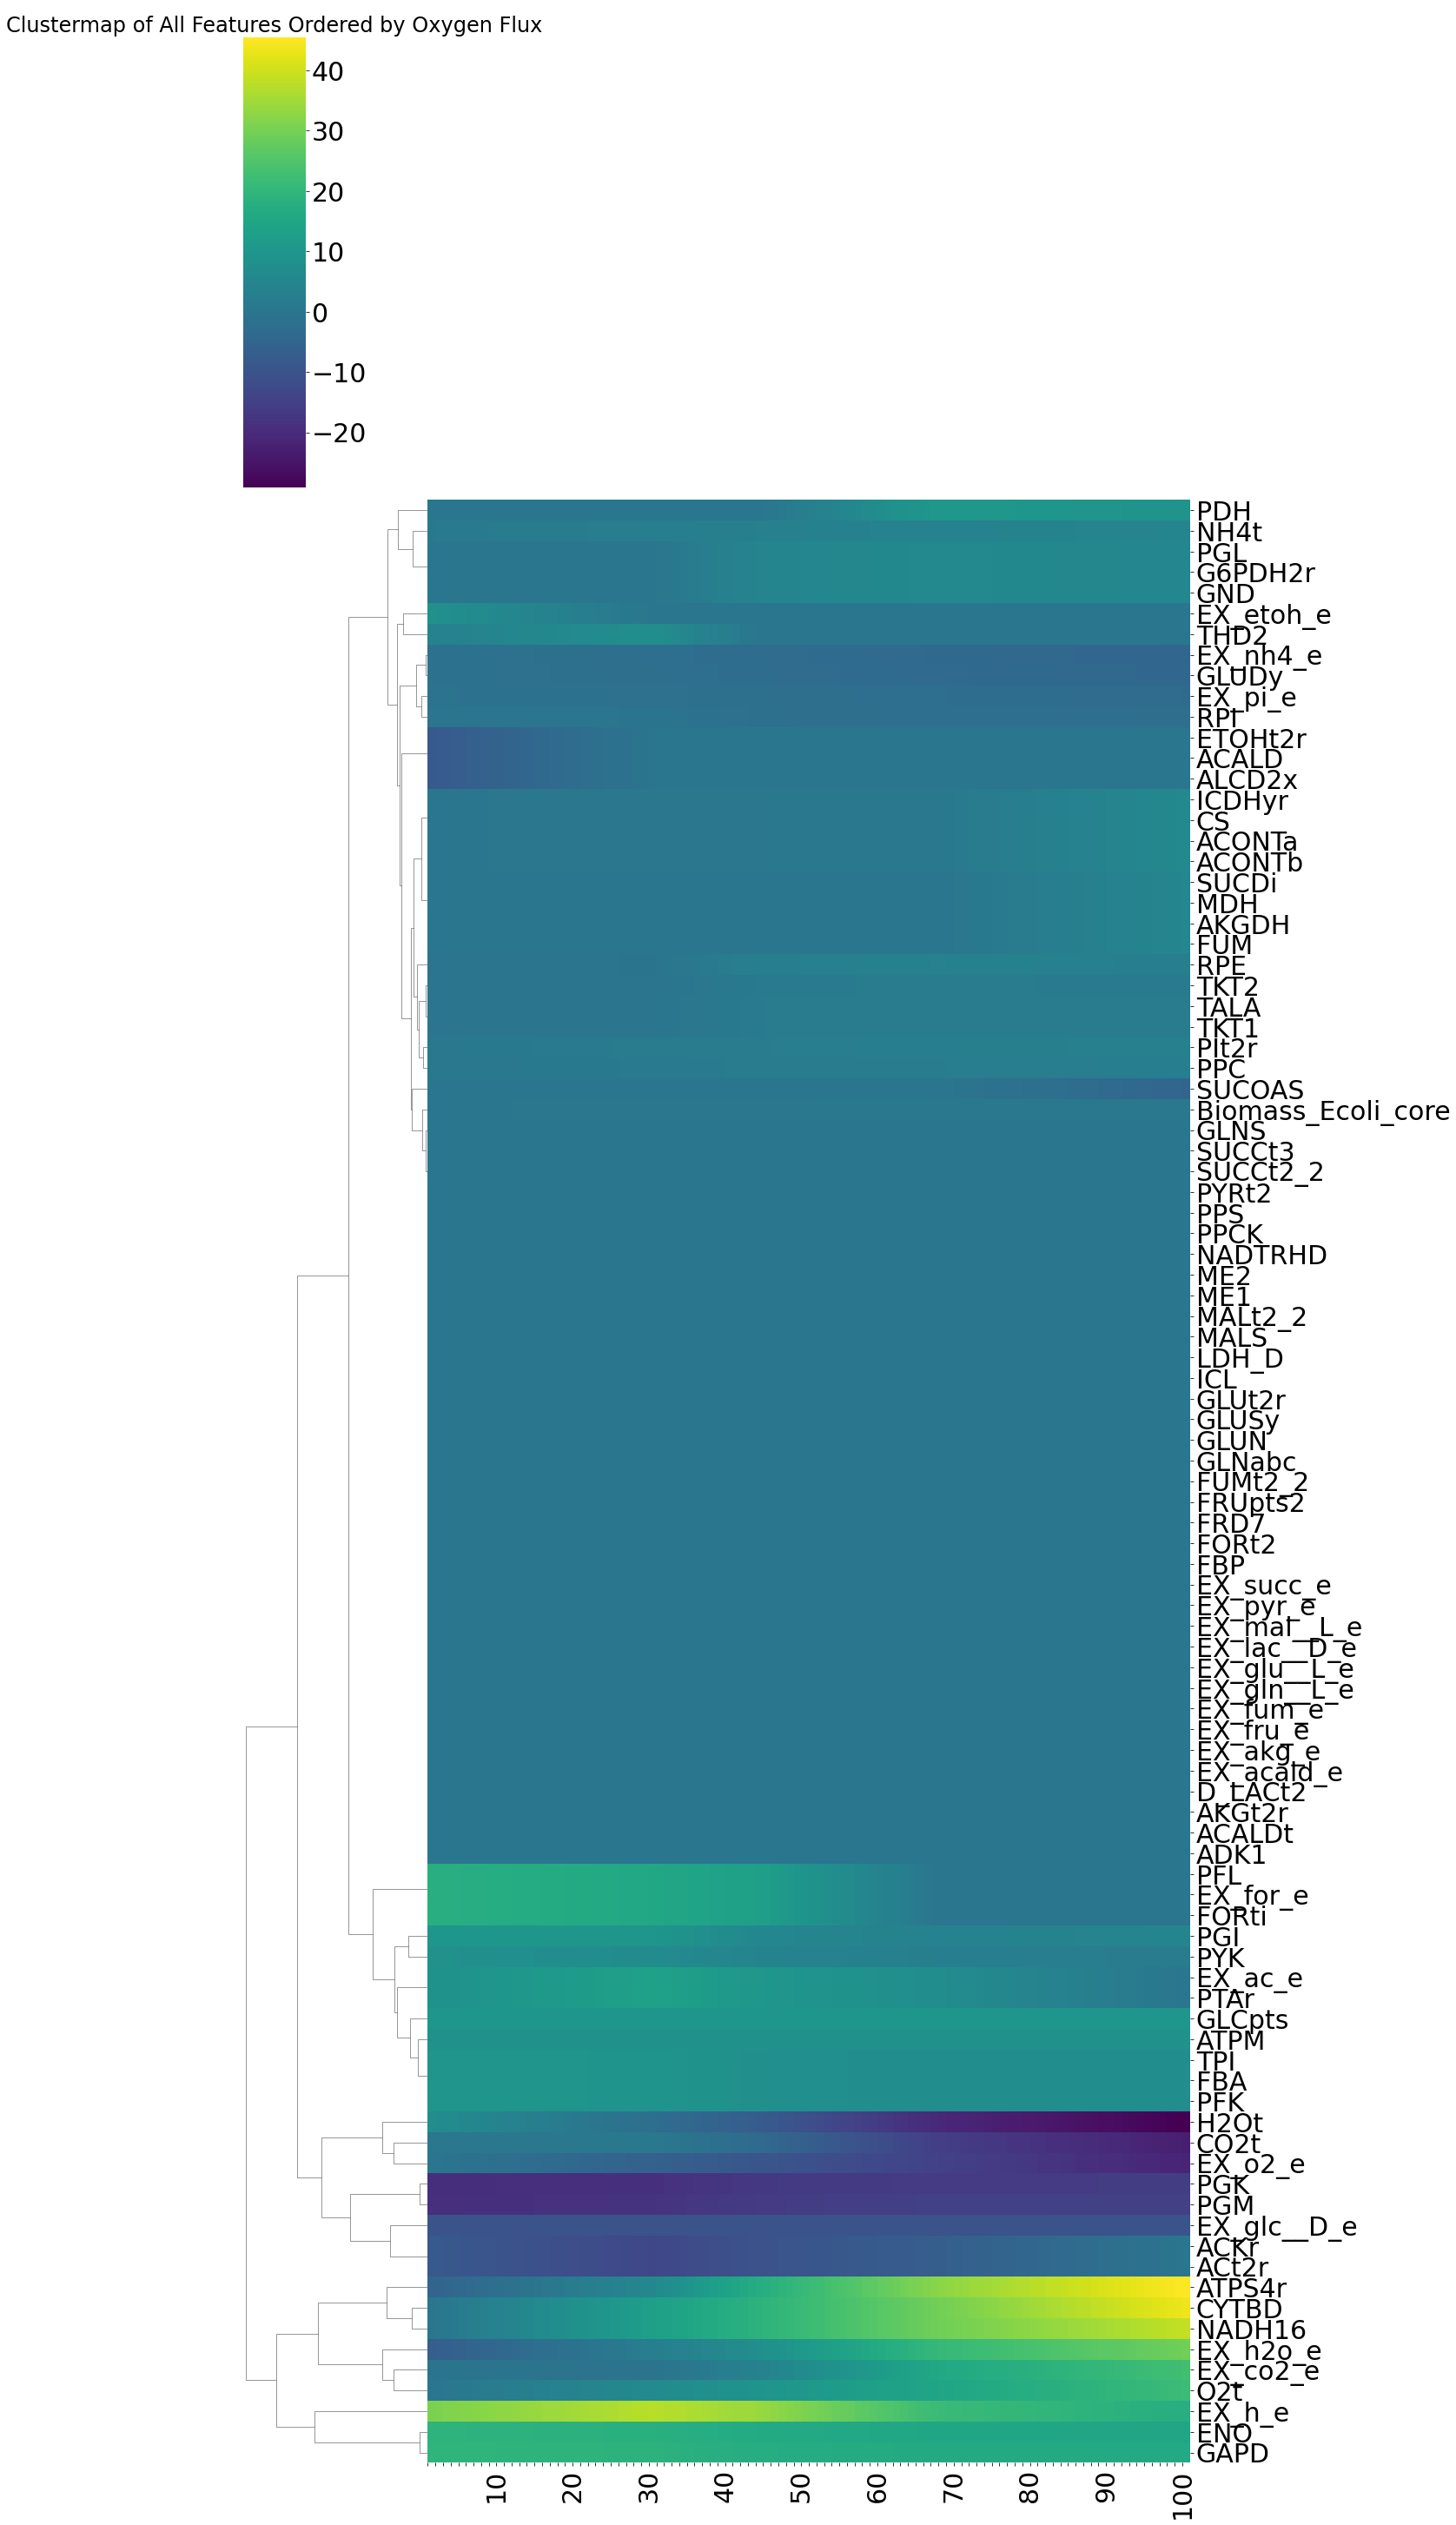

In [38]:
all_flux_data = df.transpose()  

g = seaborn.clustermap(all_flux_data, cmap = 'viridis', col_cluster = False, 
               yticklabels = True, xticklabels = False, figsize = (20, 40))

labels = [str(i) if i % 10 == 0 else '' for i in range(1, 101)] 

g.ax_heatmap.set_xticks(numpy.arange(100))
g.ax_heatmap.set_xticklabels(labels, rotation = 90)

matplotlib.pyplot.title('Clustermap of All Features')
matplotlib.pyplot.show()
# Why is the ordering different here?